**`PCA and Dimensionality Reduction`**

Often, the desired goal is to reduce the dimensions of a d-dimensional dataset by projecting it onto a (k)-dimensional subspace (where k<d) in order to increase the computational efficiency while retaining most of the information. ​

**Why PCA?**

 If your learning algorithm is too slow because the input dimension is too high, then using PCA to speed it up can be a reasonable choice. This is probably the most common application of PCA. Another common application of PCA is for data visualization.
 

**A Summary of the PCA Approach​**



*   Standardize the data.
*   Obtain the Eigenvectors and Eigenvalues from the covariance matrix or correlation matrix.
*   Sort eigenvalues in descending order and choose the k eigenvectors that correspond to the k largest eigenvalues where k is the number of dimensions of the new feature subspace (k≤d).​
*   Construct the projection matrix W from the selected k eigenvectors.​
*   Transform the original dataset X via W to obtain a k-dimensional feature subspace Y.​

**Example: Iris Dataset​**

The iris dataset contains measurements for 150 iris flowers from three different species.​

The three classes in the Iris dataset are:
    

1.  Iris-setosa (n=50)​
2.  Iris-versicolor (n=50)​
3.  Iris-virginica (n=50)​

​

And the four features of in Iris dataset are:​

1. sepal length in cm​
2. sepal width in cm​
3. petal length in cm​
4. petal width in cm​

In order to load the Iris data directly from the UCI repository, we are going to use the superb pandas library. If you haven't used pandas yet, I want encourage you to check out the pandas tutorials. If I had to name one Python library that makes working with data a wonderfully simple task, this would definitely be pandas!

**Loading the Dataset**

In [1]:
import pandas as pd

df = pd.read_csv(
    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', 
    header=None, 
    sep=',')

df.columns=['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']
df.dropna(how="all", inplace=True) # drops the empty line at file-end

df.tail()


,sepal_len,sepal_wid,petal_len,petal_wid,class
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


In [0]:


# split data table into data X and class labels y

X = df.iloc[:,0:4].values
y = df.iloc[:,4].values
#print(X)
#print(y)


**Standardizing**

Whether to standardize the data prior to a PCA on the covariance matrix depends on the measurement scales of the original features. Since PCA yields a feature subspace that maximizes the variance along the axes, it makes sense to standardize the data, especially, if it was measured on different scales. Although, all features in the Iris dataset were measured in centimeters, let us continue with the transformation of the data onto unit scale (mean=0 and variance=1), which is a requirement for the optimal performance of many machine learning algorithms.

In [0]:

#print(X.mean(axis = 0))
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)
#print(X_std.mean(axis = 0))

**Eigendecomposition - Computing Eigenvectors and Eigenvalues**

The eigenvectors and eigenvalues of a covariance (or correlation) matrix represent the "core" of a PCA: The eigenvectors (principal components) determine the directions of the new feature space, and the eigenvalues determine their magnitude. In other words, the eigenvalues explain the variance of the data along the new feature axes.


In [0]:
import numpy as np
cov_mat = np.cov(X_std.T)
#print('Covariance matrix \n%s' %cov_mat)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

#print('Eigenvectors \n%s' %eig_vecs)
#print('\nEigenvalues \n%s' %eig_vals)

**Selecting Principal Components**

The typical goal of a PCA is to reduce the dimensionality of the original feature space by projecting it onto a smaller subspace, where the eigenvectors will form the axes. However, the eigenvectors only define the directions of the new axis, since they have all the same unit length 1


In [53]:
for ev in eig_vecs:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Everything ok!')

Everything ok!


In order to decide which eigenvector(s) can dropped without losing too much information for the construction of lower-dimensional subspace, we need to inspect the corresponding eigenvalues: The eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data; those are the ones can be dropped.
In order to do so, the common approach is to rank the eigenvalues from highest to lowest in order choose the top k eigenvectors.

In [22]:
#Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort()
eig_pairs.reverse()

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
#for i in eig_pairs:
#    print(i[0])

Eigenvalues in descending order:
2.930353775589317
0.9274036215173419
0.14834222648163944
0.02074601399559593


After sorting the eigenpairs, the next question is "how many principal components are we going to choose for our new feature subspace?" A useful measure is the so-called "explained variance," which can be calculated from the eigenvalues. The explained variance tells us how much information (variance) can be attributed to each of the principal components.

In [27]:
tot = sum(eig_vals)
#print(tot)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)]
#print(var_exp)
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)

[ 72.77045209  95.80097536  99.48480732 100.        ]


It's about time to get to the really interesting part: The construction of the projection matrix that will be used to transform the Iris data onto the new feature subspace. Although, the name "projection matrix" has a nice ring to it, it is basically just a matrix of our concatenated top k eigenvectors.

Here, we are reducing the 4-dimensional feature space to a 2-dimensional feature subspace, by choosing the "top 2" eigenvectors with the highest eigenvalues to construct our d×k
-dimensional eigenvector matrix W.


In [28]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(4,1), 
                      eig_pairs[1][1].reshape(4,1)))

print('Matrix W:\n', matrix_w)

Matrix W:
 [[ 0.52237162 -0.37231836]
 [-0.26335492 -0.92555649]
 [ 0.58125401 -0.02109478]
 [ 0.56561105 -0.06541577]]


**Projection Onto the New Feature Space**

In this last step we will use the 4×2-dimensional projection matrix W to transform our samples onto the new subspace via the equation
Y=X×W, where Y is a 150×2 matrix of our transformed samples.


In [0]:
Y = X_std.dot(matrix_w)
#print(Y)

     principal component 1  principal component 2           class
0                -2.264542              -0.505704     Iris-setosa
1                -2.086426               0.655405     Iris-setosa
2                -2.367950               0.318477     Iris-setosa
3                -2.304197               0.575368     Iris-setosa
4                -2.388777              -0.674767     Iris-setosa
5                -2.070537              -1.518549     Iris-setosa
6                -2.445711              -0.074563     Iris-setosa
7                -2.233842              -0.247614     Iris-setosa
8                -2.341958               1.095146     Iris-setosa
9                -2.188676               0.448629     Iris-setosa
10               -2.163487              -1.070596     Iris-setosa
11               -2.327378              -0.158587     Iris-setosa
12               -2.224083               0.709118     Iris-setosa
13               -2.639716               0.938282     Iris-setosa
14        

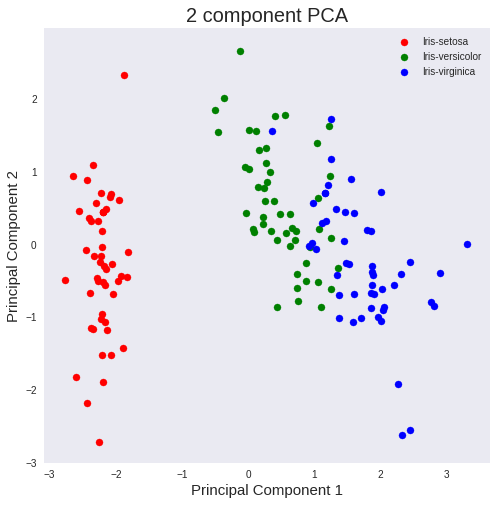

In [52]:
principalDf = pd.DataFrame(data = Y
             , columns = ['principal component 1', 'principal component 2'])

#print(Y)
finalDf = pd.concat([principalDf, df[['class']]], axis = 1)

#print(finalDf)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['class'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
